In [0]:
%restart_python

In [0]:
%pip install -e minGPT/

Obtaining file:///Workspace/Users/naman.agarwal%40dreamsports.group/minGPT
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py develop for minGPT
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
import torch
from torch.utils.data.dataloader import DataLoader
import minGPT
from minGPT.mingpt.utils import set_seed

set_seed(3407)
print(torch.cuda.device_count())
from torch.nn import functional as F

import InContextLearningExperiments.icldatasets_new_idea as datasets

1


In [0]:
import importlib
importlib.reload(datasets)
importlib.reload(minGPT)

<module 'minGPT' (<_frozen_importlib_external.NamespaceLoader object at 0x7feb6ecc85d0>)>

In [0]:
import seaborn as sns

import matplotlib.pyplot as plt

In [0]:
# Set context length (2*length+1) and vocab_size
length = 15
vocab_size = 10
train_dataset_changing_dict = datasets.KVRetrievalDatasetChangingDictNewIdeaV2('train', vocab_size=vocab_size, length=length, perm_or_random='random')


In [0]:
train_dataset_changing_dict.length

15

In [0]:
loader = DataLoader(train_dataset_changing_dict, batch_size=1, num_workers=0, drop_last=False)
next(iter(loader))

[tensor([[ 5, 18,  7, 12,  7, 12,  5, 18,  4, 10,  8, 16,  1, 17,  0, 14,  2, 19,
           7, 12,  3, 13,  8, 16,  7, 12,  8, 16,  3]]),
 tensor([[18,  7, 12,  7, 12,  5, 18,  4, 10,  8, 16,  1, 17,  0, 14,  2, 19,  7,
          12,  3, 13,  8, 16,  7, 12,  8, 16,  3, 13]])]

In [0]:
a,b = next(iter(loader))

In [0]:
a.size()

torch.Size([1, 19])

In [0]:
# create a GPT instance
from minGPT.mingpt.model import GPT
# create a Trainer object
from minGPT.mingpt.trainer import Trainer

model_config = GPT.get_default_config()
model_config.model_type = 'gpt-mini'
model_config.vocab_size = 2*vocab_size
model_config.block_size = 2*length - 1

train_config = Trainer.get_default_config()
train_config.learning_rate = 5e-5 # the model we're using is so small that we can go a bit faster
train_config.max_iters = 20000
train_config.num_workers = 0

def batch_end_callback(trainer):
    if trainer.iter_num % 100 == 0:
        print(f"iter_dt {trainer.iter_dt * 1000:.2f}ms; iter {trainer.iter_num}: train loss {trainer.loss.item():.5f}")

In [0]:
model_fixed_dict = GPT(model_config)
trainer_fixed_dict = Trainer(train_config, model_fixed_dict, train_dataset_changing_dict)
trainer_fixed_dict.set_callback('on_batch_end', batch_end_callback)
trainer_fixed_dict.run()

number of parameters: 2.68M
running on device cuda
Print to test changes are going though
iter_dt 0.00ms; iter 0: train loss 3.05263
iter_dt 19.94ms; iter 100: train loss 2.36202
iter_dt 20.20ms; iter 200: train loss 2.32692
iter_dt 20.43ms; iter 300: train loss 2.31554
iter_dt 20.11ms; iter 400: train loss 2.31280
iter_dt 20.10ms; iter 500: train loss 2.30946
iter_dt 19.95ms; iter 600: train loss 2.30975
iter_dt 20.00ms; iter 700: train loss 2.31012
iter_dt 19.90ms; iter 800: train loss 2.30563
iter_dt 19.92ms; iter 900: train loss 2.30716
iter_dt 20.02ms; iter 1000: train loss 2.30766
iter_dt 19.96ms; iter 1100: train loss 2.30604
iter_dt 20.26ms; iter 1200: train loss 2.30592
iter_dt 19.86ms; iter 1300: train loss 2.30630
iter_dt 20.35ms; iter 1400: train loss 2.30546
iter_dt 20.18ms; iter 1500: train loss 2.30579
iter_dt 20.02ms; iter 1600: train loss 2.30459
iter_dt 20.02ms; iter 1700: train loss 2.30518
iter_dt 20.29ms; iter 1800: train loss 2.30565
iter_dt 20.35ms; iter 1900: tr

In [0]:
(np.log(np.arange(vocab_size, 0, -1)).sum() + (length-1)*np.log(vocab_size))/(2*length - 1)

1.6324346163790395

In [0]:
a,b = next(iter(loader))
ans=model_fixed_dict.generate(a.to(trainer_fixed_dict.device), 1, do_sample=False)
print(a)
print(b)
print(ans[0])

tensor([[ 7, 17,  3, 13,  3, 13,  8, 14,  3, 13,  9, 16,  9, 16,  7, 17,  5, 19,
          8, 14,  6, 12,  3, 13,  1, 18,  5, 19,  3]])
tensor([[17,  3, 13,  3, 13,  8, 14,  3, 13,  9, 16,  9, 16,  7, 17,  5, 19,  8,
         14,  6, 12,  3, 13,  1, 18,  5, 19,  3, 13]])
tensor([[ 7, 17,  3, 13,  3, 13,  8, 14,  3, 13,  9, 16,  9, 16,  7, 17,  5, 19,
          8, 14,  6, 12,  3, 13,  1, 18,  5, 19,  3, 13]], device='cuda:0')


In [0]:
probs = F.softmax(ans[1], dim=-1)

In [0]:
probs

tensor([[[2.2788e-05, 2.1900e-05, 2.2068e-05, 2.1812e-05, 2.2733e-05,
          2.2156e-05, 2.2923e-05, 2.3285e-05, 2.1898e-05, 2.2509e-05,
          8.4160e-02, 9.9296e-02, 9.2593e-02, 9.8714e-02, 9.5514e-02,
          7.4090e-02, 1.1845e-01, 1.0534e-01, 1.2375e-01, 1.0787e-01],
         [1.0400e-01, 1.0056e-01, 9.7247e-02, 9.8574e-02, 1.0497e-01,
          9.7084e-02, 1.0117e-01, 9.6179e-02, 1.0492e-01, 9.5171e-02,
          1.3976e-05, 1.0392e-05, 1.2427e-05, 1.2845e-05, 1.5631e-05,
          1.5705e-05, 1.2447e-05, 2.0685e-05, 1.3102e-05, 7.7183e-06],
         [2.1409e-05, 2.1662e-05, 2.1826e-05, 2.2140e-05, 2.1378e-05,
          2.2223e-05, 2.0365e-05, 2.2080e-05, 1.9436e-05, 2.3899e-05,
          1.3726e-01, 9.8940e-02, 1.1781e-01, 1.2479e-01, 1.0938e-01,
          1.0082e-01, 1.2082e-01, 1.2695e-03, 8.7354e-02, 1.0135e-01],
         [1.0602e-01, 1.0030e-01, 9.5665e-02, 1.0194e-01, 1.0086e-01,
          9.5422e-02, 9.9058e-02, 1.0228e-01, 1.0531e-01, 9.2981e-02,
          1.3129e

In [0]:
probs.size(1)

19

In [0]:
from scipy.stats import entropy
import numpy as np

tensor([[ 7, 17,  3, 13,  3, 13,  8, 14,  3, 13,  9, 16,  9, 16,  7, 17,  5, 19,
          8, 14,  6, 12,  3, 13,  1, 18,  5, 19,  3]])
tensor([[17,  3, 13,  3, 13,  8, 14,  3, 13,  9, 16,  9, 16,  7, 17,  5, 19,  8,
         14,  6, 12,  3, 13,  1, 18,  5, 19,  3, 13]])
7 17
{}
3 13
{7: 17}
3 13
{7: 17, 3: 13}
8 14
{7: 17, 3: 13}
3 13
{7: 17, 3: 13, 8: 14}
9 16
{7: 17, 3: 13, 8: 14}
9 16
{7: 17, 3: 13, 8: 14, 9: 16}
7 17
{7: 17, 3: 13, 8: 14, 9: 16}
5 19
{7: 17, 3: 13, 8: 14, 9: 16}
8 14
{7: 17, 3: 13, 8: 14, 9: 16, 5: 19}
6 12
{7: 17, 3: 13, 8: 14, 9: 16, 5: 19}
3 13
{7: 17, 3: 13, 8: 14, 9: 16, 5: 19, 6: 12}
1 18
{7: 17, 3: 13, 8: 14, 9: 16, 5: 19, 6: 12}
5 19
{7: 17, 3: 13, 8: 14, 9: 16, 5: 19, 6: 12, 1: 18}
3 13
{7: 17, 3: 13, 8: 14, 9: 16, 5: 19, 6: 12, 1: 18}


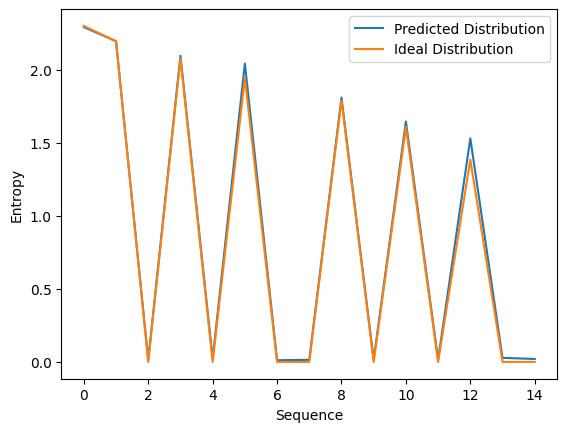

In [0]:
dict_so_far = {}
things_fixed = 0
entropies = []
true_entropies = []
print(a)
print(b)
for i in range(0, ans[1].size(1), 2):
  q = a[0][i].cpu().item()
  qa = b[0][i].cpu().item()
  print(q, qa)
  print(dict_so_far)
  if q in dict_so_far:
    true_entropies.append(np.log(1))
  else:
    true_entropies.append(np.log(vocab_size - things_fixed))
    dict_so_far[q] = qa
    things_fixed += 1
  entropies.append(entropy(probs[0][i].cpu().numpy()))
  #plt.plot(probs[0][i][10:].cpu().numpy(), label='p(y_t|x,y_1,...,y_{t-1})')
plt.plot(entropies, label='Predicted Distribution')
plt.plot(true_entropies, label='Ideal Distribution')
plt.xlabel('Sequence')
plt.ylabel('Entropy')
plt.legend()
plt.show()


In [0]:
(np.log(np.arange(vocab_size, vocab_size-length, -1)).sum() + (length-1)*np.log(length))/(2*length - 1)

2.3071076567371187

In [0]:
import numpy as np
import math
(np.log(math.factorial(10)) + np.log(math.factorial(9)))/(2*length - 1)

1.4687494764819466

In [0]:

# running a non cl trained trainer through non_cl dataset
with torch.no_grad():
    train_score_fixed_dict = eval_split(trainer_fixed_dict, model_fixed_dict, train_dataset_fixed_dict, max_batches=50, split='train')
    test_score_fixed_dict  = eval_split(trainer_fixed_dict, model_fixed_dict, test_dataset_fixed_dict, max_batches=50, split='test')
    test_score_changing_dict = eval_split(trainer_fixed_dict, model_fixed_dict, test_dataset_changing_dict, max_batches=50, split='test')
    test_score_mixed_dict_x1 = eval_split(trainer_fixed_dict, model_fixed_dict, test_dataset_mixed_dict_x1, max_batches=50, split='test')

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
train final score: 5000/5000 = 100.00% correct
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
test final score: 5000/5000 = 100.00% correct
1
GPT claims that [5, 4, 2, 6, 8, 2, 2, 6, 4, 0, 5, 4, 2] sorted is 5 but gt is 6
GPT claims that [1, 8, 3, 1, 2, 9, 3, 1, 6, 2, 0, 3, 3] sorted is 7 but gt is 1
GPT claims that [7, 7, 8, 1, 4, 6, 6, 5, 1, 4, 1, 4, 7] sorted is 6 but gt is 7
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
test final score: 493/5000 = 9.86% correct
1
GPT claims that [9, 6, 8, 5, 4, 0, 7, 3, 0, 8, 6, 4, 9] sorted is 0 but gt is 6
GPT claims that [8, 9, 2, 1, 9, 7, 4, 4, 5, 8, 9, 7, 5] sorted is 2 but gt is 8
GPT claims that [0, 4, 9, 1, 2, 2, 9, 1, 1, 9, 0, 4, 0] sorted is 9 but gt is 4
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


In [0]:
loader = DataLoader(test_dataset_fixed_dict, batch_size=1, num_workers=0, drop_last=False)
a = next(iter(loader))
a = [a[0].to(trainer_fixed_dict.device), a[1].to(trainer_fixed_dict.device)]

In [0]:

print(a)
with torch.no_grad():
  cat, att_matrices = model_fixed_dict.generate(a[0], 1, do_sample=False)
  print(cat)
  print(att_matrices)

[tensor([[9, 0, 8, 4, 5, 2, 9, 0, 7, 6, 9, 0, 5]], device='cuda:0'), tensor([[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  2]], device='cuda:0')]
tensor([[9, 0, 8, 4, 5, 2, 9, 0, 7, 6, 9, 0, 5, 2]], device='cuda:0')
[[tensor([[[[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.2695, 0.7305, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.3080, 0.4632, 0.2288, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.2296, 0.2736, 0.2282, 0.2685, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.1660, 0.1683, 0.2112, 0.1742, 0.2803, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.1892, 0.1197, 0.1411, 0.1102, 0.1009, 0.3389, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.177

In [0]:
from matplotlib.colors import LogNorm, Normalize
import numpy as np
import pandas as pd

<class 'torch.Tensor'>
torch.Size([1, 3, 13, 13])


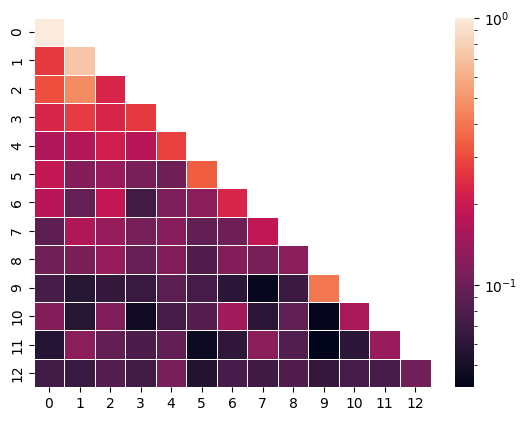

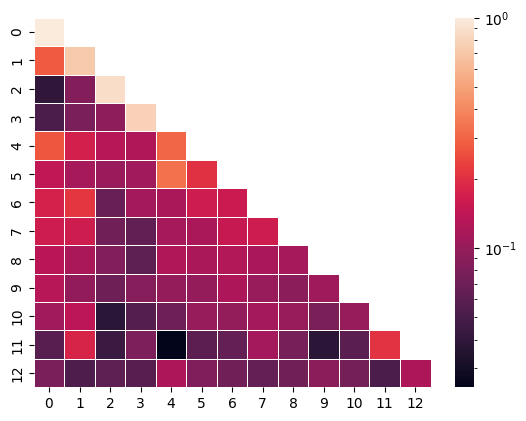

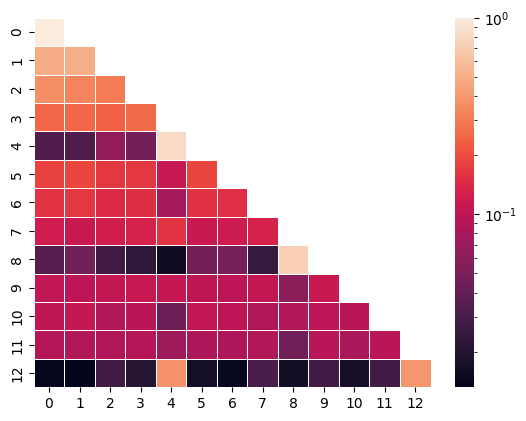

In [0]:
print(type(att_matrices[0][0]))
print(att_matrices[0][0].size())
for i in range(att_matrices[0][0].size()[1]):
  #plt.imshow(att_matrices[0][0][0][i].cpu(), cmap='hot', interpolation='nearest')
  ax = sns.heatmap(att_matrices[0][0][0][i].cpu(), linewidth=0.5, norm=LogNorm())
  plt.show()

In [0]:
def prettyprint(A):
  A = np.array(A)
  A = pd.DataFrame(A)
  A.columns = ['']*A.shape[1]
  print(A.to_string(index=False))

In [0]:
prettyprint(att_matrices[0][0][0][0].cpu())

                                                                                                                    
1.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000
0.269497 0.730503 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000
0.308010 0.463151 0.228839 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000
0.229616 0.273639 0.228209 0.268535 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000
0.166004 0.168291 0.211204 0.174227 0.280274 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000
0.189196 0.119671 0.141106 0.110227 0.100873 0.338927 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000
0.177108 0.094432 0.189303 0.071495 0.113394 0.127045 0.227221 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000
0.088933 0.165189 0.136423 0.107717 0.122513 0.092669 0.099894 0

In [0]:
model_changing_dict = GPT(model_config)
train_config.max_iters = 10000
trainer_changing_dict = Trainer(train_config, model_changing_dict, train_dataset_changing_dict)
trainer_changing_dict.set_callback('on_batch_end', batch_end_callback)
trainer_changing_dict.run()

number of parameters: 0.09M
running on device cuda
iter_dt 0.00ms; iter 0: train loss 2.32059
iter_dt 12.50ms; iter 100: train loss 2.15733
iter_dt 13.75ms; iter 200: train loss 2.05771
iter_dt 12.57ms; iter 300: train loss 1.90284
iter_dt 12.35ms; iter 400: train loss 1.97802
iter_dt 12.57ms; iter 500: train loss 1.76750
iter_dt 12.87ms; iter 600: train loss 1.58136
iter_dt 12.80ms; iter 700: train loss 1.78509
iter_dt 12.59ms; iter 800: train loss 1.70332
iter_dt 14.10ms; iter 900: train loss 1.64320
iter_dt 14.02ms; iter 1000: train loss 1.73345
iter_dt 13.19ms; iter 1100: train loss 1.64181
iter_dt 13.19ms; iter 1200: train loss 1.75181
iter_dt 12.75ms; iter 1300: train loss 1.61917
iter_dt 13.87ms; iter 1400: train loss 1.59685
iter_dt 12.62ms; iter 1500: train loss 1.50174
iter_dt 12.64ms; iter 1600: train loss 1.80803
iter_dt 12.69ms; iter 1700: train loss 1.63901
iter_dt 13.95ms; iter 1800: train loss 1.73235
iter_dt 12.43ms; iter 1900: train loss 1.50058
iter_dt 12.60ms; iter 

In [0]:
# running a non cl trained trainer through non_cl dataset
with torch.no_grad():
    train_score_changing_dict = eval_split(trainer_changing_dict, model_changing_dict, train_dataset_changing_dict, max_batches=50, split='train')
    test_score_fixed_dict  = eval_split(trainer_changing_dict, model_changing_dict, test_dataset_fixed_dict, max_batches=50, split='test')
    test_score_changing_dict = eval_split(trainer_changing_dict, model_changing_dict, test_dataset_changing_dict, max_batches=50, split='test')
    test_score_mixed_dict_x1 = eval_split(trainer_changing_dict, model_changing_dict, test_dataset_mixed_dict_x1, max_batches=50, split='test')

GPT claims that [0, 0, 7, 2, 0, 0, 0, 0, 2, 5, 6, 6, 0] sorted is 5 but gt is 0
GPT claims that [8, 8, 5, 1, 3, 4, 2, 3, 1, 7, 7, 9, 8] sorted is 6 but gt is 8
GPT claims that [8, 8, 0, 2, 2, 0, 2, 0, 7, 4, 1, 9, 8] sorted is 0 but gt is 8
train final score: 4993/5000 = 99.86% correct
GPT claims that [1, 1, 9, 0, 2, 5, 7, 6, 3, 7, 5, 2, 7] sorted is 2 but gt is 6
GPT claims that [1, 1, 0, 9, 5, 2, 6, 8, 9, 0, 4, 3, 9] sorted is 2 but gt is 0
GPT claims that [0, 9, 0, 9, 1, 1, 1, 1, 0, 9, 7, 6, 1] sorted is 9 but gt is 1
test final score: 4987/5000 = 99.74% correct
GPT claims that [1, 5, 4, 2, 5, 8, 5, 8, 3, 6, 0, 4, 3] sorted is 8 but gt is 6
GPT claims that [5, 2, 1, 4, 4, 8, 9, 5, 4, 8, 2, 0, 9] sorted is 2 but gt is 5
GPT claims that [4, 9, 2, 3, 4, 9, 5, 8, 2, 3, 9, 4, 9] sorted is 9 but gt is 4
test final score: 4985/5000 = 99.70% correct
GPT claims that [4, 3, 9, 0, 2, 5, 1, 1, 2, 5, 8, 4, 9] sorted is 5 but gt is 0
GPT claims that [0, 9, 1, 1, 7, 6, 0, 9, 0, 9, 1, 1, 1] sorted i

In [0]:
model_mixed_dict_x1 = GPT(model_config)
train_config.max_iters = 10000
trainer_mixed_dict_x1 = Trainer(train_config, model_mixed_dict_x1, train_dataset_mixed_dict_x1)
trainer_mixed_dict_x1.set_callback('on_batch_end', batch_end_callback)
trainer_mixed_dict_x1.run()

number of parameters: 0.09M
running on device cuda
Print to test changes are going though
iter_dt 0.00ms; iter 0: train loss 2.31494
iter_dt 13.74ms; iter 100: train loss 0.57485
iter_dt 13.74ms; iter 200: train loss 0.53255
iter_dt 18.30ms; iter 300: train loss 0.40923
iter_dt 13.95ms; iter 400: train loss 0.43687
iter_dt 13.77ms; iter 500: train loss 0.24094
iter_dt 13.60ms; iter 600: train loss 0.63664
iter_dt 14.26ms; iter 700: train loss 0.44738
iter_dt 13.72ms; iter 800: train loss 0.35075
iter_dt 13.96ms; iter 900: train loss 0.31174
iter_dt 13.86ms; iter 1000: train loss 0.16719
iter_dt 13.83ms; iter 1100: train loss 0.34252
iter_dt 14.01ms; iter 1200: train loss 0.32845
iter_dt 14.00ms; iter 1300: train loss 0.25798
iter_dt 13.92ms; iter 1400: train loss 0.34722
iter_dt 14.15ms; iter 1500: train loss 0.24603
iter_dt 13.91ms; iter 1600: train loss 0.16025
iter_dt 13.89ms; iter 1700: train loss 0.22432
iter_dt 13.71ms; iter 1800: train loss 0.20419
iter_dt 14.00ms; iter 1900: tr

In [0]:
loader = DataLoader(dataset, batch_size=100, num_workers=0, drop_last=False)
for b, (x, y) in enumerate(loader):
    #print(x,y)
    x = x.to(trainer.device)
    y = y.to(trainer.device)
    # isolate the input pattern alone
    inp = x
    sol = y[:, -1]
    #print(inp.size())
    # let the model sample the rest of the sequence
    cat, att_matrices = model.generate(inp, 1, do_sample=False) # using greedy argmax, not sampling
    print(len(att_matrices))
    sol_candidate = cat[:, -1] # isolate the filled in sequence
    # compare the predicted sequence to the true sequence
    #print(sol, sol_candidate)
    correct = (sol == sol_candidate).cpu() # Software 1.0 vs. Software 2.0 fight RIGHT on this line haha
    #print(x.size(0))
    #print(correct)
    for i in range(x.size(0)):
        results.append(int(correct[i]))
        if not correct[i] and mistakes_printed_already < 3: # only print up to 5 mistakes to get a sense
            mistakes_printed_already += 1
            print("GPT claims that %s sorted is %s but gt is %s" % (inp[i].tolist(), sol_candidate[i].tolist(), sol[i].tolist()))
    if max_batches is not None and b+1 >= max_batches:
        break

In [0]:
print(train_dataset_mixed_dict_x1.dictionary)
print(train_dataset_fixed_dict.dictionary)

tensor([9, 1, 5, 7, 3, 2, 8, 6, 4, 0])
tensor([9, 1, 5, 7, 3, 2, 8, 6, 4, 0])


In [0]:
with torch.no_grad():
    train_score_mixed_dict_x1 = eval_split(trainer_mixed_dict_x1, model_mixed_dict_x1, train_dataset_mixed_dict_x1, max_batches=50, split='train')
    test_score_fixed_dict  = eval_split(trainer_mixed_dict_x1, model_mixed_dict_x1, test_dataset_fixed_dict, max_batches=50, split='test')
    test_score_changing_dict = eval_split(trainer_mixed_dict_x1, model_mixed_dict_x1, test_dataset_changing_dict, max_batches=50, split='test')
    test_score_mixed_dict_x1 = eval_split(trainer_mixed_dict_x1, model_mixed_dict_x1, test_dataset_mixed_dict_x1, max_batches=50, split='test')

GPT claims that [6, 5, 7, 7, 3, 0, 3, 0, 3, 0, 9, 1, 6] sorted is 0 but gt is 5
GPT claims that [9, 0, 4, 3, 0, 9, 5, 2, 6, 8, 3, 7, 5] sorted is 6 but gt is 2
GPT claims that [3, 5, 6, 9, 1, 8, 6, 9, 6, 9, 5, 3, 3] sorted is 3 but gt is 5
train final score: 4989/5000 = 99.78% correct
GPT claims that [2, 5, 5, 2, 0, 9, 2, 5, 7, 6, 2, 5, 0] sorted is 2 but gt is 9
GPT claims that [3, 7, 2, 5, 5, 2, 5, 2, 9, 0, 8, 4, 3] sorted is 3 but gt is 7
GPT claims that [9, 0, 6, 8, 2, 5, 3, 7, 2, 5, 7, 6, 9] sorted is 5 but gt is 0
test final score: 4992/5000 = 99.84% correct
GPT claims that [7, 6, 0, 8, 4, 3, 3, 9, 6, 5, 4, 3, 0] sorted is 3 but gt is 8
GPT claims that [9, 2, 6, 6, 2, 5, 5, 9, 7, 3, 1, 0, 9] sorted is 0 but gt is 2
GPT claims that [0, 3, 6, 4, 4, 0, 1, 1, 4, 0, 3, 6, 6] sorted is 6 but gt is 4
test final score: 4946/5000 = 98.92% correct
GPT claims that [4, 3, 2, 5, 4, 3, 7, 6, 6, 8, 4, 3, 7] sorted is 9 but gt is 6
GPT claims that [8, 0, 5, 4, 0, 7, 7, 1, 3, 3, 5, 4, 8] sorted i

In [0]:
from torch.utils.data import Dataset

class KVRetrievalDatasetMixedDictSeparatedVocab(Dataset):
    """ 
    Dataset for InContext Learning. 
    """

    def __init__(self, split, length=6, vocab_size=10, additional_vocab = 2, dictionary=None, mixing_fraction=0.0):
        assert split in {'train', 'test'}
        self.split = split
        self.length = length
        self.vocab_size = 2*vocab_size + additional_vocab
        self.true_vocab_size = vocab_size
        self.mixing_fraction = mixing_fraction
        self.dictionary = dictionary if dictionary is not None else self._generate_dictionary()
          
    def _generate_dictionary(self):
        return torch.randperm(self.true_vocab_size)

    def _generate_extended_dictionary(self):
        return torch.randperm(self.true_vocab_size) + self.true_vocab_size

    def __len__(self):
        return 10000 # ...
    
    def get_vocab_size(self):
        return self.vocab_size
    
    def get_block_size(self):
        # the length of the sequence that will feed into transformer, 
        # containing concatenated input and the output, but -1 because
        # the transformer starts making predictions at the last input element
        return 2*self.length + 1

    def __getitem__(self, idx):
        decider = torch.rand(1) < 0.5
        dictionary = self.dictionary if decider else self._generate_extended_dictionary()
        context_keys = torch.randint(self.true_vocab_size, size=(self.length,), dtype=torch.long)
        context_labels = torch.index_select(dictionary, 0, context_keys)
        # find a key thats appeared in this context
        question_key = torch.index_select(context_keys, 0, torch.randint(self.length, size=(1,), dtype=torch.long))
        question_label = torch.index_select(dictionary, 0, question_key)
        # make final context
        context_keys = torch.concat([context_keys, question_key], dim=0) if decider else torch.concat([context_keys + self.true_vocab_size, question_key + self.true_vocab_size], dim=0)
        context_labels = torch.concat([context_labels, question_label], dim=0)


        
        #interleave them
        full_context = torch.flatten(torch.stack([context_keys, context_labels]).t())
        # provide everything but the last label to TX
        x = full_context[:-1].clone()
        # Mask everything but the last label in the loss
        y = full_context[1:].clone()
        y[:2*self.length] = -1
        return x, y

In [0]:
train_dataset_mixed_dict_x1_sep_vocab = KVRetrievalDatasetMixedDictSeparatedVocab('train', length=length, dictionary=train_dataset_fixed_dict.dictionary, mixing_fraction=0.5, vocab_size=vocab_size)

In [0]:
print(train_dataset_mixed_dict_x1_sep_vocab.dictionary)
print(train_dataset_fixed_dict.dictionary)

for i in range(15):
  print(train_dataset_mixed_dict_x1_sep_vocab[i])

tensor([9, 1, 5, 7, 3, 2, 8, 6, 4, 0])
tensor([9, 1, 5, 7, 3, 2, 8, 6, 4, 0])
(tensor([13, 16, 10, 18, 10, 18, 14, 11, 19, 15, 12, 19, 10]), tensor([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 18]))
(tensor([7, 6, 0, 9, 4, 3, 9, 0, 4, 3, 8, 4, 7]), tensor([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  6]))
(tensor([17, 13, 13, 16, 19, 14, 19, 14, 16, 11, 12, 10, 13]), tensor([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 16]))
(tensor([15, 11, 19, 14, 16, 10, 14, 19, 11, 17, 15, 11, 14]), tensor([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 19]))
(tensor([14, 12, 18, 15, 19, 19, 10, 17, 18, 15, 10, 17, 10]), tensor([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 17]))
(tensor([11, 15, 15, 10, 11, 15, 16, 17, 11, 15, 16, 17, 16]), tensor([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 17]))
(tensor([11, 17, 11, 17, 12, 12, 11, 17, 16, 13, 11, 17, 11]), tensor([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 17]))
(tensor([13, 17, 12, 12, 10, 15, 15, 16, 13, 17, 16, 18, 10]

In [0]:
model_config = GPT.get_default_config()
model_config.model_type = 'gpt-nano'
model_config.vocab_size = 2*vocab_size+2
model_config.block_size = 2*length + 1

train_config = Trainer.get_default_config()
train_config.learning_rate = 5e-4 # the model we're using is so small that we can go a bit faster
train_config.max_iters = 50000
train_config.num_workers = 0

model_mixed_dict_x1_sep_vocab = GPT(model_config)
trainer_mixed_dict_x1_sep_vocab = Trainer(train_config, model_mixed_dict_x1_sep_vocab, train_dataset_mixed_dict_x1_sep_vocab)
trainer_mixed_dict_x1_sep_vocab.set_callback('on_batch_end', batch_end_callback)
trainer_mixed_dict_x1_sep_vocab.run()

number of parameters: 0.09M
running on device cuda
iter_dt 0.00ms; iter 0: train loss 3.13697
iter_dt 13.80ms; iter 100: train loss 1.64139
iter_dt 14.57ms; iter 200: train loss 1.14677
iter_dt 13.89ms; iter 300: train loss 1.22756
iter_dt 13.84ms; iter 400: train loss 1.14750
iter_dt 13.76ms; iter 500: train loss 1.21383
iter_dt 13.85ms; iter 600: train loss 0.71264
iter_dt 13.73ms; iter 700: train loss 0.95512
iter_dt 14.54ms; iter 800: train loss 0.94221
iter_dt 13.65ms; iter 900: train loss 0.74103
iter_dt 13.59ms; iter 1000: train loss 1.08887
iter_dt 14.07ms; iter 1100: train loss 0.56927
iter_dt 13.76ms; iter 1200: train loss 0.64409
iter_dt 13.77ms; iter 1300: train loss 0.95438
iter_dt 13.86ms; iter 1400: train loss 0.83682
iter_dt 13.76ms; iter 1500: train loss 0.76936
iter_dt 13.83ms; iter 1600: train loss 0.91122
iter_dt 13.89ms; iter 1700: train loss 0.89596
iter_dt 14.03ms; iter 1800: train loss 0.86192
iter_dt 13.85ms; iter 1900: train loss 0.94112
iter_dt 13.80ms; iter 

In [0]:
with torch.no_grad():
    train_score_mixed_dict_x1_sep_vocab = eval_split(trainer_mixed_dict_x1_sep_vocab, model_mixed_dict_x1_sep_vocab, train_dataset_mixed_dict_x1_sep_vocab, max_batches=50, split='train')
    test_score_fixed_dict  = eval_split(trainer_mixed_dict_x1_sep_vocab, model_mixed_dict_x1_sep_vocab, test_dataset_fixed_dict, max_batches=50, split='test')
    test_score_changing_dict = eval_split(trainer_mixed_dict_x1_sep_vocab, model_mixed_dict_x1_sep_vocab, test_dataset_changing_dict, max_batches=50, split='test')
    test_score_mixed_dict_x1 = eval_split(trainer_mixed_dict_x1_sep_vocab, model_mixed_dict_x1_sep_vocab, test_dataset_mixed_dict_x1, max_batches=50, split='test')

GPT claims that [18, 13, 16, 14, 10, 19, 16, 14, 10, 19, 11, 17, 11] sorted is 14 but gt is 17
GPT claims that [19, 18, 15, 15, 11, 16, 11, 16, 10, 11, 12, 19, 15] sorted is 19 but gt is 15
GPT claims that [16, 11, 17, 12, 10, 14, 15, 19, 19, 16, 12, 18, 12] sorted is 12 but gt is 18
train final score: 4995/5000 = 99.90% correct
test final score: 5000/5000 = 100.00% correct
GPT claims that [2, 3, 0, 5, 8, 1, 2, 3, 9, 6, 9, 6, 2] sorted is 5 but gt is 3
GPT claims that [2, 2, 7, 9, 7, 9, 5, 1, 1, 3, 7, 9, 7] sorted is 6 but gt is 9
GPT claims that [3, 7, 4, 2, 3, 7, 6, 4, 9, 6, 7, 0, 4] sorted is 3 but gt is 2
test final score: 535/5000 = 10.70% correct
GPT claims that [7, 1, 5, 4, 2, 0, 8, 7, 7, 1, 3, 9, 7] sorted is 6 but gt is 1
GPT claims that [4, 8, 7, 3, 5, 0, 4, 8, 9, 5, 1, 1, 7] sorted is 6 but gt is 3
GPT claims that [1, 9, 4, 2, 5, 7, 8, 5, 7, 4, 3, 8, 7] sorted is 6 but gt is 4
test final score: 4558/5000 = 91.16% correct


In [0]:
# running a non cl trained trainer through non_cl dataset
# shows roughly random accuracy
with torch.no_grad():
    train_score = eval_split(trainer_non_cl, model_non_cl, train_dataset_cl, max_batches=50, split='train')

GPT claims that [4, 9, 2, 8, 2, 8, 7, 7, 8, 5, 1, 6, 2] sorted is 5 but gt is 8
GPT claims that [6, 6, 1, 9, 8, 2, 7, 8, 2, 1, 7, 8, 1] sorted is 1 but gt is 9
GPT claims that [9, 4, 4, 9, 9, 4, 2, 8, 8, 1, 6, 3, 6] sorted is 8 but gt is 3
train final score: 517/5000 = 10.34% correct


In [0]:
# even when we try a long sequence of repeatedly the right prompts 
inp = torch.tensor([[6, 7]*length + [6]])
inp = inp.to(trainer_non_cl.device)
print(inp, inp.size())
with torch.no_grad():
  cat = model_non_cl.generate(inp, 1, do_sample=False)
  print(cat)

tensor([[6, 7, 6, 7, 6, 7, 6, 7, 6, 7, 6, 7, 6]], device='cuda:0') torch.Size([1, 13])
tensor([[6, 7, 6, 7, 6, 7, 6, 7, 6, 7, 6, 7, 6, 8]], device='cuda:0')


In [0]:
# what if we try introducing a new key does thats not in voacb
inp = torch.tensor([[11, 7]*length + [10]])
inp = inp.to(trainer_non_cl.device)
print(inp, inp.size())
with torch.no_grad():
  cat = model_non_cl.generate(inp, 1, do_sample=False)
  print(cat)

tensor([[11,  7, 11,  7, 11,  7, 11,  7, 11,  7, 11,  7, 10]], device='cuda:0') torch.Size([1, 13])
tensor([[11,  7, 11,  7, 11,  7, 11,  7, 11,  7, 11,  7, 10,  1]],
       device='cuda:0')


In [0]:
model_config = GPT.get_default_config()
model_config.model_type = 'gpt-nano'
model_config.vocab_size = train_dataset_cl.get_vocab_size()
model_config.block_size = train_dataset_cl.get_block_size()

train_config = Trainer.get_default_config()
train_config.learning_rate = 5e-4 # the model we're using is so small that we can go a bit faster
train_config.max_iters = 10000
train_config.num_workers = 0

model_cl = GPT(model_config)
trainer_cl = Trainer(train_config, model_cl, train_dataset_cl)

def batch_end_callback(trainer):
    if trainer.iter_num % 100 == 0:
        print(f"iter_dt {trainer.iter_dt * 1000:.2f}ms; iter {trainer.iter_num}: train loss {trainer.loss.item():.5f}")

trainer_cl.set_callback('on_batch_end', batch_end_callback)

trainer_cl.run()

number of parameters: 0.09M
running on device cuda
iter_dt 0.00ms; iter 0: train loss 2.47862
iter_dt 12.98ms; iter 100: train loss 2.10638
iter_dt 12.68ms; iter 200: train loss 1.90885
iter_dt 12.86ms; iter 300: train loss 1.71111
iter_dt 12.54ms; iter 400: train loss 1.70856
iter_dt 12.63ms; iter 500: train loss 1.70365
iter_dt 12.89ms; iter 600: train loss 1.78062
iter_dt 12.95ms; iter 700: train loss 1.80131
iter_dt 12.81ms; iter 800: train loss 1.68473
iter_dt 12.96ms; iter 900: train loss 1.66459
iter_dt 12.76ms; iter 1000: train loss 1.84441
iter_dt 12.73ms; iter 1100: train loss 1.82064
iter_dt 13.04ms; iter 1200: train loss 1.72650
iter_dt 12.82ms; iter 1300: train loss 1.67664
iter_dt 12.71ms; iter 1400: train loss 1.61046
iter_dt 12.70ms; iter 1500: train loss 1.82549
iter_dt 12.91ms; iter 1600: train loss 1.58476
iter_dt 12.73ms; iter 1700: train loss 1.77136
iter_dt 12.82ms; iter 1800: train loss 1.68561
iter_dt 13.26ms; iter 1900: train loss 1.61742
iter_dt 12.59ms; iter 

In [0]:
with torch.no_grad():
    train_score = eval_split(trainer_cl, model_cl, train_dataset_cl, max_batches=50, split='train')

GPT claims that [9, 3, 6, 2, 5, 8, 4, 0, 0, 7, 5, 8, 6] sorted is 3 but gt is 2
GPT claims that [5, 8, 8, 2, 6, 9, 1, 4, 5, 8, 7, 6, 6] sorted is 8 but gt is 9
GPT claims that [5, 8, 1, 3, 4, 2, 5, 8, 6, 4, 8, 5, 8] sorted is 6 but gt is 5
train final score: 4975/5000 = 99.50% correct


In [0]:
# even when we try a long sequence of repeatedly the right prompts 
inp = torch.tensor([[6, 7]*length + [6]])
inp = inp.to(trainer_cl.device)
print(inp, inp.size())
with torch.no_grad():
  cat = model_cl.generate(inp, 1, do_sample=False)
  print(cat)

tensor([[6, 7, 6, 7, 6, 7, 6, 7, 6, 7, 6, 7, 6]], device='cuda:0') torch.Size([1, 13])
tensor([[6, 7, 6, 7, 6, 7, 6, 7, 6, 7, 6, 7, 6, 7]], device='cuda:0')


In [0]:
# even when we try a long sequence of repeatedly the right prompts 
inp = torch.tensor([[11, 7]*length + [11]])
inp = inp.to(trainer_cl.device)
print(inp, inp.size())
with torch.no_grad():
  cat = model_cl.generate(inp, 1, do_sample=False)
  print(cat)

tensor([[11,  7, 11,  7, 11,  7, 11,  7, 11,  7, 11,  7, 11]], device='cuda:0') torch.Size([1, 13])
tensor([[11,  7, 11,  7, 11,  7, 11,  7, 11,  7, 11,  7, 11,  7]],
       device='cuda:0')


In [0]:
# even when we try a long sequence of repeatedly the right prompts 
inp = torch.tensor([[1, 2, 1, 2, 1, 2, 11, 7, 1, 2, 1, 2] + [11]])
inp = inp.to(trainer_cl.device)
print(inp, inp.size())
with torch.no_grad():
  cat = model_cl.generate(inp, 1, do_sample=False)
  print(cat)

tensor([[ 1,  2,  1,  2,  1,  2, 11,  7,  1,  2,  1,  2, 11]], device='cuda:0') torch.Size([1, 13])
tensor([[ 1,  2,  1,  2,  1,  2, 11,  7,  1,  2,  1,  2, 11,  7]],
       device='cuda:0')


In [0]:
# even when we try a long sequence of repeatedly the right prompts 
inp = torch.tensor([[1, 2, 11, 3, 1, 2, 11, 7, 1, 2, 11, 5] + [11]])
inp = inp.to(trainer_cl.device)
print(inp, inp.size())
with torch.no_grad():
  for i in range(30):
    cat = model_cl.generate(inp, 1, do_sample=False)
    print(cat[0, -1])

tensor([[ 1,  2, 11,  3,  1,  2, 11,  7,  1,  2, 11,  5, 11]], device='cuda:0') torch.Size([1, 13])
tensor(7, device='cuda:0')
tensor(3, device='cuda:0')
tensor(3, device='cuda:0')
tensor(3, device='cuda:0')
tensor(7, device='cuda:0')
tensor(3, device='cuda:0')
tensor(3, device='cuda:0')
tensor(7, device='cuda:0')
tensor(5, device='cuda:0')
tensor(3, device='cuda:0')
tensor(7, device='cuda:0')
tensor(3, device='cuda:0')
tensor(7, device='cuda:0')
tensor(3, device='cuda:0')
tensor(3, device='cuda:0')
tensor(7, device='cuda:0')
tensor(7, device='cuda:0')
tensor(3, device='cuda:0')
tensor(7, device='cuda:0')
tensor(3, device='cuda:0')
tensor(3, device='cuda:0')
tensor(3, device='cuda:0')
tensor(7, device='cuda:0')
tensor(7, device='cuda:0')
tensor(3, device='cuda:0')
tensor(7, device='cuda:0')
tensor(3, device='cuda:0')
tensor(3, device='cuda:0')
tensor(7, device='cuda:0')
tensor(7, device='cuda:0')


In [0]:
# Generating mixed datasets

class KVRetrievalDatasetMixedDict(Dataset):
    """ 
    Dataset for InContext Learning. 
    """

    def __init__(self, split, length=6, vocab_size=10, additional_vocab = 2, dictionary=None, mixing_fraction=0.0):
        assert split in {'train', 'test'}
        self.split = split
        self.length = length
        self.vocab_size = vocab_size + additional_vocab
        self.true_vocab_size = vocab_size
        self.mixing_fraction = mixing_fraction
        self.dictionary = dictionary if dictionary is not None else self._generate_dictionary()
          
    def _generate_dictionary(self):
        return torch.randperm(self.true_vocab_size)

    def __len__(self):
        return 10000 # ...
    
    def get_vocab_size(self):
        return self.vocab_size
    
    def get_block_size(self):
        # the length of the sequence that will feed into transformer, 
        # containing concatenated input and the output, but -1 because
        # the transformer starts making predictions at the last input element
        return 2*self.length + 1

    def __getitem__(self, idx):
        dictionary = self.dictionary if torch.rand(1) < self.mixing_fraction else self._generate_dictionary()
        context_keys = torch.randint(self.true_vocab_size, size=(self.length,), dtype=torch.long)
        context_labels = torch.index_select(dictionary, 0, context_keys)
        # find a key thats appeared in this context
        question_key = torch.index_select(context_keys, 0, torch.randint(self.length, size=(1,), dtype=torch.long))
        question_label = torch.index_select(dictionary, 0, question_key)
        # make final context
        context_keys = torch.concat([context_keys, question_key], dim=0)
        context_labels = torch.concat([context_labels, question_label], dim=0)
        
        #interleave them
        full_context = torch.flatten(torch.stack([context_keys, context_labels]).t())
        # provide everything but the last label to TX
        x = full_context[:-1].clone()
        # Mask everything but the last label in the loss
        y = full_context[1:].clone()
        y[:2*self.length] = -1
        return x, y


In [0]:
torch.rand(1)

tensor([0.2246])

In [0]:

train_dataset_cl_mixed = KVRetrievalDatasetMixedDict('train', length=length, mixing_fraction=0.9)

model_config = GPT.get_default_config()
model_config.model_type = 'gpt-nano'
model_config.vocab_size = train_dataset_cl.get_vocab_size()
model_config.block_size = train_dataset_cl.get_block_size()

train_config = Trainer.get_default_config()
train_config.learning_rate = 5e-4 # the model we're using is so small that we can go a bit faster
train_config.max_iters = 10000
train_config.num_workers = 0

model_cl_mixed = GPT(model_config)
trainer_cl_mixed = Trainer(train_config, model_cl_mixed, train_dataset_cl_mixed)

def batch_end_callback(trainer):
    if trainer.iter_num % 100 == 0:
        print(f"iter_dt {trainer.iter_dt * 1000:.2f}ms; iter {trainer.iter_num}: train loss {trainer.loss.item():.5f}")

trainer_cl_mixed.set_callback('on_batch_end', batch_end_callback)

trainer_cl_mixed.run()

number of parameters: 0.09M
running on device cuda
iter_dt 0.00ms; iter 0: train loss 2.47012
iter_dt 12.98ms; iter 100: train loss 0.74165
iter_dt 13.14ms; iter 200: train loss 0.62282
iter_dt 13.21ms; iter 300: train loss 0.40717
iter_dt 12.90ms; iter 400: train loss 0.52125
iter_dt 13.40ms; iter 500: train loss 0.41293
iter_dt 13.06ms; iter 600: train loss 0.26446
iter_dt 13.39ms; iter 700: train loss 0.25332
iter_dt 13.70ms; iter 800: train loss 0.27812
iter_dt 13.31ms; iter 900: train loss 0.12942
iter_dt 13.76ms; iter 1000: train loss 0.33237
iter_dt 14.14ms; iter 1100: train loss 0.12031
iter_dt 13.40ms; iter 1200: train loss 0.17841
iter_dt 13.54ms; iter 1300: train loss 0.38096
iter_dt 13.49ms; iter 1400: train loss 0.30287
iter_dt 13.52ms; iter 1500: train loss 0.20512
iter_dt 13.54ms; iter 1600: train loss 0.33354
iter_dt 13.33ms; iter 1700: train loss 0.19630
iter_dt 13.38ms; iter 1800: train loss 0.46864
iter_dt 13.37ms; iter 1900: train loss 0.27285
iter_dt 13.42ms; iter 

In [0]:
train_dataset_cl_mixed.dictionary

tensor([9, 6, 8, 0, 7, 4, 2, 5, 1, 3])

In [0]:
with torch.no_grad():
    train_score = eval_split(trainer_cl_mixed, model_cl_mixed, train_dataset_cl_mixed, max_batches=50, split='train')

GPT claims that [3, 0, 1, 6, 9, 3, 2, 8, 0, 9, 9, 3, 2] sorted is 6 but gt is 8
GPT claims that [1, 6, 0, 9, 0, 9, 5, 4, 9, 3, 8, 1, 5] sorted is 9 but gt is 4
GPT claims that [9, 3, 6, 2, 0, 9, 1, 6, 9, 3, 4, 7, 6] sorted is 3 but gt is 2
train final score: 4987/5000 = 99.74% correct


In [0]:
# run the trainer with an accuracy module on test data to generate some plots

# next experiment should be using different vocabs for incontext and different vocabs for distributional. Can it still do in context for the vocab that it didnt learn in context for? 




In [0]:
from scipy.stats import binom
import numpy as np

n = np.arange(5, 15, 1)
p = np.arange(0, 1, 0.05)
n = 1024

cdf_value = [binom.cdf(n//2, n, p_test) for p_test in p]

print(cdf_value)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999999594005, 0.9994025630810964, 0.5124639029464901, 0.0007426158813180409, 6.14710625554844e-11, 5.733998967058023e-23, 7.398609952070017e-41, 4.011456488099696e-66, 1.928862707499965e-101, 5.7105330833317175e-152, 1.8818495009837187e-229, 0.0]


In [0]:
n

1024

In [0]:
binom.cdf(4, 8, 0.1)

0.99956835